In [1]:
#These lines set up inline plotting, and apply a standard size
%matplotlib inline
import matplotlib

import numpy as np
import matplotlib.pyplot as plt
import datetime
import re
from elasticsearch import Elasticsearch, exceptions as es_exceptions
from elasticsearch.helpers import scan
matplotlib.rc('font', **{'size': 15})

#Create instance of ElasticSearch using the Atlas host server
es = Elasticsearch(hosts=[{'host':'atlas-kibana-2.mwt2.org', 'port':9200}],timeout=60)
 

In [2]:
query = '''{
  "size": 10000,
  "sort": [
    {
      "@timestamp": {
        "order": "desc",
        "unmapped_type": "boolean"
      }
    }
  ],
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "payload.src-rse:CERN* AND payload.dst-rse:BNL* AND event_type:transfer-done",
          "analyze_wildcard": True,
          "lowercase_expanded_terms": False
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "range": {
                "@timestamp": {
                  "gte": %i,
                  "lte": %i,
                  "format": "epoch_millis"
                }
              }
            }
          ],
          "must_not": []
        }
      }
    }
  },

  "script_fields": {},
  "fielddata_fields": [
    "@timestamp","duration"
  ]
}'''

In [132]:
import ast
import time
currentMilliTime = int(round(time.time()*1000))
milliWeek = 7*24*60*60*1000
milliTwoWeek = 2*7*24*60*60*1000
milliMonth = 30*24*60*60*1000
milliDay = 24*60*60*1000
milliHour = 60*60*1000

#Get files from hour interval
start = currentMilliTime - milliDay
end = currentMilliTime

response = es.search(index="rucio-events*", body=ast.literal_eval(query%(start,end)), request_timeout=600)

In [133]:
#Get important variables from response

fileSize = []
activity = []
startedAt = []
submittedAt = []
transferredAt = []
duration = []
timestamp = []
for r in response['hits']['hits']:
    timestamp.append(r['fields']['@timestamp'])
    fileSize.append(r['_source']['payload']['file-size'])
    activity.append(r['_source']['payload']['activity'])
    startedAt.append(r['_source']['payload']['started_at'])
    submittedAt.append(r['_source']['payload']['submitted_at'])
    transferredAt.append(r['_source']['payload']['transferred_at'])
    duration.append(r['_source']['payload']['duration'])

In [134]:
fileSize = np.array(fileSize)
activity = np.array(activity)

uniqueActivity = np.unique(activity)

In [135]:
import datetime
from datetime import datetime as dt
import time

#Some useful functions for date conversion

def convertDateToEpoch(dates):
    
    epochDates = []
    
    for i in range(len(dates)):
        #Use decimal version if the date string contains a decimal point
        if dates[i].find('.')==-1:
            epoch = dt.strptime(dates[i], "%Y-%m-%d %H:%M:%S")
        else:
            epoch = dt.strptime(dates[i], "%Y-%m-%d %H:%M:%S.%f")
        epochDates.append(epoch)
    return epochDates

def getSecondsDifference(epochDatesStart,epochDatesFinal):
    diff = []
    for i in range(len(epochDatesStart)):
        diff.append((epochDatesFinal[i] - epochDatesStart[i]).total_seconds())
    
    return diff

In [136]:
#Convert string timestamps to usable quantities

timeInQueue = getSecondsDifference(convertDateToEpoch(submittedAt),
                                   convertDateToEpoch(startedAt))
timeTotal = getSecondsDifference(convertDateToEpoch(submittedAt),
                                 convertDateToEpoch(transferredAt))
timeInTransfer = getSecondsDifference(convertDateToEpoch(startedAt),
                                      convertDateToEpoch(transferredAt))

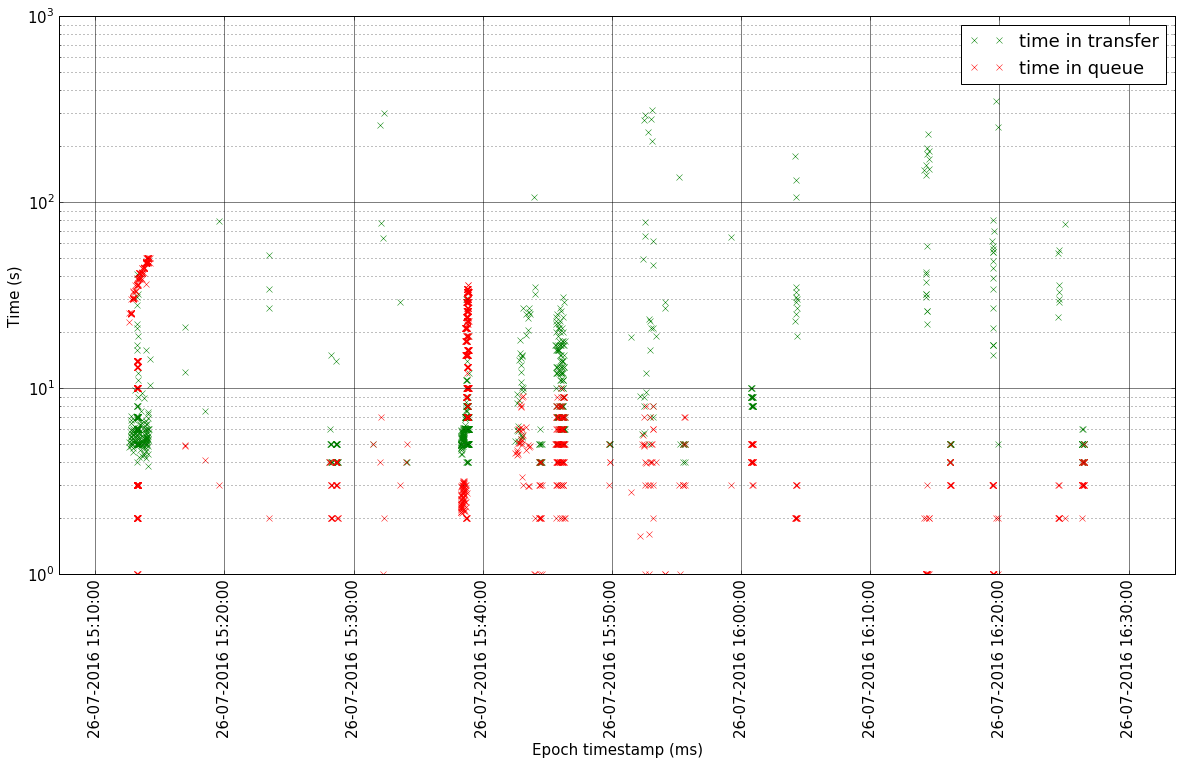

In [139]:
import matplotlib.dates as dt

timestamp = np.array(timestamp)
dateTime = dt.epoch2num(timestamp/1000.)
plt.figure(figsize=(20,10))
plt.semilogy(dateTime,timeInTransfer,'gx',label='time in transfer')
plt.semilogy(dateTime,timeInQueue,'rx',label='time in queue')
plt.grid(which='minor')
plt.grid(which='major',linestyle='-')
plt.xlabel('Epoch timestamp (ms)')
plt.ylabel('Time (s)')
plt.xticks(rotation= 90 )
plt.legend()

ax = plt.gca()
#Tedious date/time formatting
xfmt = dt.DateFormatter('%d-%m-%Y %H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)
ax.xaxis_date()


In [127]:
print(timestamp[0])
print(1469544153914)
print(currentMilliTime)

[1469544153944]
1469544153914
1469544255013


In [62]:
from sklearn import tree, cross_validation,preprocessing
import pandas as pd

#Build dictionary
data = {'activity':activity,'filesize':fileSize}

#Convert to panda dataframe, convert categorical, and convert back
df = pd.DataFrame(data)
dummyActivity = np.array(pd.get_dummies(df['activity']))
treeData = np.hstack((dummyActivity,fileSize[:,None]))


#Create decision tree regressor and fit to data, holding some data
#back for validation

clf = tree.DecisionTreeRegressor(min_samples_split=20,random_state = 90)
clf = clf.fit(treeData,np.array(timeInQueue,dtype=np.int64))


In [ ]:
1469544153914